In [31]:
import pandas as pd
import fastparquet
import matplotlib.pyplot as plt

In [21]:
import glob

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.manifold import TSNE
from sklearn.preprocessing import minmax_scale


def calc_price_from_tick(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path,
                         columns=[
                             'time_id',
                             'ask_price1',
                             'ask_price2',
                             'bid_price1',
                             'bid_price2'
                         ])
    df = df.groupby('time_id') \
        .apply(calc_price_from_tick).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


def reconstruct_time_id_order():
    paths = glob.glob('optiver-realized-volatility-prediction/book_train.parquet/stock_id=0/c439ef22282f412ba39e9137a3fdabac.parquet')

    df_files = pd.DataFrame(
        {'book_path': paths}) \
        .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")',
              engine='python')

    # build price matrix using tick-size
    df_prices = pd.concat(
        Parallel(n_jobs=4)(
            delayed(calc_prices)(r) for _, r in df_files.iterrows()
        )
    )
    df_prices = df_prices.pivot('time_id', 'stock_id', 'price')

    # t-SNE to recovering time-id order
    clf = TSNE(
        n_components=1,
        perplexity=400,
        random_state=0,
        n_iter=2000
    )
    compressed = clf.fit_transform(
        pd.DataFrame(minmax_scale(df_prices.fillna(df_prices.mean())))
    )

    order = np.argsort(compressed[:, 0])
    ordered = df_prices.reindex(order).reset_index(drop=True)

    # correct direction of time-id order using known stock (id61 = AMZN)
    if ordered[61].iloc[0] > ordered[61].iloc[-1]:
        ordered = ordered.reindex(ordered.index[::-1])\
            .reset_index(drop=True)

    return ordered[['time_id']]


<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:35: SyntaxWarning: invalid escape sequence '\d'
C:\Users\asus\AppData\Local\Temp\ipykernel_22988\3487068877.py:35: SyntaxWarning: invalid escape sequence '\d'
  .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")',


In [20]:
target_feature = 'book.log_return1.realized_volatility'
n_max = 40

# make neighbors
pivot = df.pivot('time_id', 'stock_id', 'price')
pivot = pivot.fillna(pivot.mean())
pivot = pd.DataFrame(minmax_scale(pivot))

nn = NearestNeighbors(n_neighbors=n_max, p=1)
nn.fit(pivot)
neighbors = nn.kneighbors(pivot)

# aggregate

def make_nn_feature(df, neighbors, f_col, n=5, agg=np.mean, postfix=''):
    pivot_aggs = pd.DataFrame(agg(neighbors[1:n,:,:], axis=0), 
                              columns=feature_pivot.columns, 
                              index=feature_pivot.index)
    dst = pivot_aggs.unstack().reset_index()
    dst.columns = ['stock_id', 'time_id', f'{f_col}_cluster{n}{postfix}_{agg.__name__}']
    return dst

feature_pivot = df.pivot('time_id', 'stock_id', target_feature)
feature_pivot = feature_pivot.fillna(feature_pivot.mean())

neighbor_features = np.zeros((n_max, *feature_pivot.shape))

for i in range(n):
    neighbor_features[i, :, :] += feature_pivot.values[neighbors[:, i], :]

for n in [2, 3, 5, 10, 20, 40]:
    dst = make_nn_feature(df, neighbors, feature_pivot, n)
    df = pd.merge(df, dst, on=['stock_id', 'time_id'], how='left')


TypeError: DataFrame.pivot() takes 1 positional argument but 4 were given

In [34]:
book_train = pd.read_parquet(r'C:\Users\asus\Desktop\Bid ask data\optiver-realized-volatility-prediction\book_train.parquet\stock_id=0')
book_train

,time_id,seconds_in_bucket,bid_price1,ask_price1,bid_price2,ask_price2,bid_size1,ask_size1,bid_size2,ask_size2
0,5,0,1.001422,1.002301,1.001370,1.002353,3,226,2,100
1,5,1,1.001422,1.002301,1.001370,1.002353,3,100,2,100
2,5,5,1.001422,1.002301,1.001370,1.002405,3,100,2,100
3,5,6,1.001422,1.002301,1.001370,1.002405,3,126,2,100
4,5,7,1.001422,1.002301,1.001370,1.002405,3,126,2,100
...,...,...,...,...,...,...,...,...,...,...
917548,32767,568,0.998275,0.998754,0.997796,0.998946,90,90,48,28
917549,32767,569,0.998275,0.998754,0.997892,0.998946,91,90,200,28
917550,32767,571,0.998275,0.998754,0.997892,0.998946,91,90,100,28
917551,32767,572,0.998275,0.998754,0.997892,0.998946,92,90,100,28


In [33]:
trade_train = pd.read_parquet(r"C:\Users\asus\Desktop\Bid ask data\optiver-realized-volatility-prediction\trade_train.parquet\stock_id=0")
trade_train

,time_id,seconds_in_bucket,price,size,order_count
0,5,21,1.002301,326,12
1,5,46,1.002778,128,4
2,5,50,1.002818,55,1
3,5,57,1.003155,121,5
4,5,68,1.003646,4,1
...,...,...,...,...,...
123438,32767,471,0.998659,200,3
123439,32767,517,0.998515,90,1
123440,32767,523,0.998563,1,1
123441,32767,542,0.998803,90,4


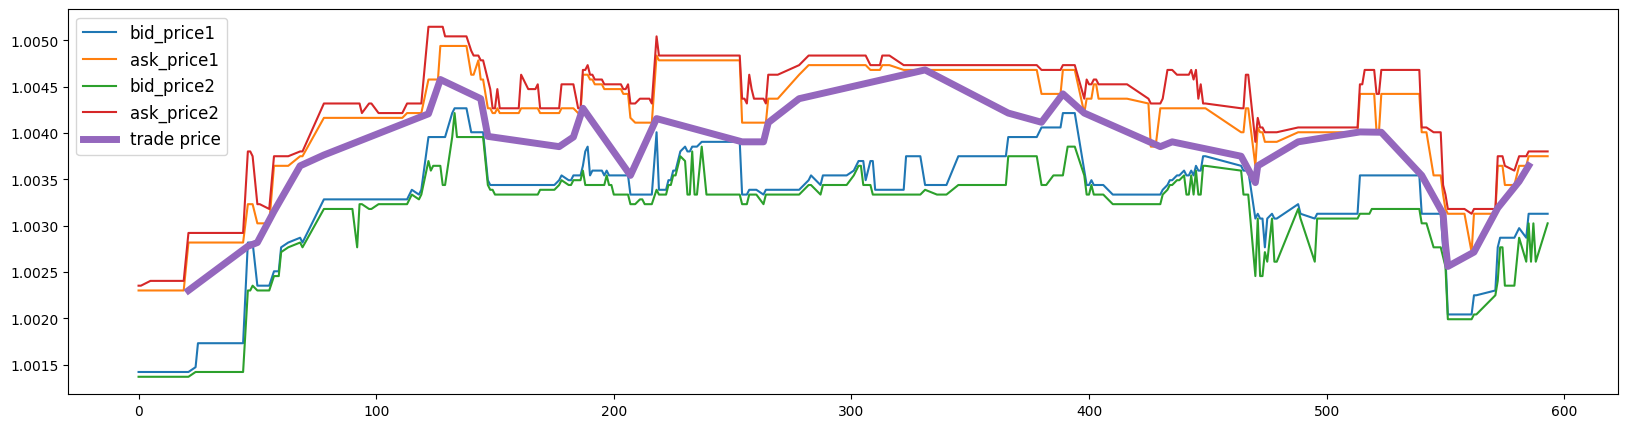

In [35]:


book_to_plot = book_train.loc[book_train.time_id==5]
trade_to_plot = trade_train.loc[trade_train.time_id==5]

samples = ['bid_price1', 'ask_price1','bid_price2', 'ask_price2']
plt.figure(figsize=(20,5))
for feature in samples: 
    plt.plot(book_to_plot["seconds_in_bucket"], book_to_plot[feature], label=feature)
plt.plot(trade_to_plot["seconds_in_bucket"],trade_to_plot["price"], label="trade price", lw=5)
plt.legend(fontsize=12)

In [39]:
train = pd.read_csv(r"C:\Users\asus\Desktop\Bid ask data\optiver-realized-volatility-prediction\train.csv")
train

,stock_id,time_id,target
0,0,5,0.004136
1,0,11,0.001445
2,0,16,0.002168
3,0,31,0.002195
4,0,62,0.001747
...,...,...,...
428927,126,32751,0.003461
428928,126,32753,0.003113
428929,126,32758,0.004070
428930,126,32763,0.003357


In [42]:
test = pd.read_csv(r"C:\Users\asus\Desktop\Bid ask data\optiver-realized-volatility-prediction\test.csv")
test

,stock_id,time_id,row_id
0,0,4,0-4
1,0,32,0-32
2,0,34,0-34


In [43]:
import glob

import numpy as np
import pandas as pd
from joblib import Parallel, delayed
from sklearn.manifold import TSNE
from sklearn.preprocessing import minmax_scale


def calc_price_from_tick(df):
    tick = sorted(np.diff(sorted(np.unique(df.values.flatten()))))[0]
    return 0.01 / tick


def calc_prices(r):
    df = pd.read_parquet(r.book_path,
                         columns=[
                             'time_id',
                             'ask_price1',
                             'ask_price2',
                             'bid_price1',
                             'bid_price2'
                         ])
    df = df.groupby('time_id') \
        .apply(calc_price_from_tick).to_frame('price').reset_index()
    df['stock_id'] = r.stock_id
    return df


def reconstruct_time_id_order():
    paths = glob.glob('/kaggle/input/optiver-realized-volatility-prediction/book_train.parquet/**/*.parquet')

    df_files = pd.DataFrame(
        {'book_path': paths}) \
        .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")',
              engine='python')

    # build price matrix using tick-size
    df_prices = pd.concat(
        Parallel(n_jobs=4)(
            delayed(calc_prices)(r) for _, r in df_files.iterrows()
        )
    )
    df_prices = df_prices.pivot('time_id', 'stock_id', 'price')

    # t-SNE to recovering time-id order
    clf = TSNE(
        n_components=1,
        perplexity=400,
        random_state=0,
        n_iter=2000
    )
    compressed = clf.fit_transform(
        pd.DataFrame(minmax_scale(df_prices.fillna(df_prices.mean())))
    )

    order = np.argsort(compressed[:, 0])
    ordered = df_prices.reindex(order).reset_index(drop=True)

    # correct direction of time-id order using known stock (id61 = AMZN)
    if ordered[61].iloc[0] > ordered[61].iloc[-1]:
        ordered = ordered.reindex(ordered.index[::-1])\
            .reset_index(drop=True)

    return ordered[['time_id']]


<>:35: SyntaxWarning: invalid escape sequence '\d'
<>:35: SyntaxWarning: invalid escape sequence '\d'
C:\Users\asus\AppData\Local\Temp\ipykernel_22988\2729665341.py:35: SyntaxWarning: invalid escape sequence '\d'
  .eval('stock_id = book_path.str.extract("stock_id=(\d+)").astype("int")',


In [62]:
!pip install category_encoders
import gc
import numpy as np
import pandas as pd
import lightgbm as lgbm
import category_encoders as ce
import matplotlib.pyplot as plt

from sklearn.metrics import make_scorer
from sklearn.model_selection import RandomizedSearchCV

np.random.seed(2024)

DATA_DIR = r'C:\Users\asus\Desktop\Bid ask data\optiver-realized-volatility-prediction'

Defaulting to user installation because normal site-packages is not writeable


In [63]:

def book_preprocess(file_path):
    
    df = pd.read_parquet(file_path)
    
    df['wap1'] = (df['bid_price1'] * df['ask_size1'] + df['ask_price1'] * df['bid_size1'])/(df['bid_size1'] + df['ask_size1'])
    df['log_ret1'] = df.groupby('time_id')['wap1'].transform(lambda x: calc_log_ret(x.to_numpy())) # Each time_id is a window having several time stamps
    
    df['wap2'] = (df['bid_price2'] * df['ask_size2'] + df['ask_price2'] * df['bid_size2'])/(df['bid_size2'] + df['ask_size2'])
    df['log_ret2'] = df.groupby('time_id')['wap2'].transform(lambda x: calc_log_ret(x.to_numpy())) # Each time_id is a window having several time stamps
    
    df['wap_balance'] = df['wap1'] - df['wap2']
    
    df['price_spread'] = (df['ask_price1'] - df['bid_price1']) / ((df['ask_price1'] + df['bid_price1'])/2)
    df['bid_spread'] = df['bid_price1'] - df['bid_price2']
    df['ask_spread'] = df['ask_price1'] - df['ask_price2']
    
    df['total_volume'] = df['ask_size1'] + df['ask_size2'] + df['bid_size1'] + df['bid_size2']
    df['volume_imbalance'] = abs((df['ask_size1'] + df['ask_size2']) - (df['bid_size1'] + df['bid_size2']))
    
    create_feature_dict = {
        'log_ret1': ['std'],
        'log_ret2': ['std'],
        'wap_balance': ['mean', 'std'],
        'price_spread': ['mean', 'std'],
        'bid_spread': ['mean', 'std'],
        'ask_spread': ['mean', 'std'],
        'volume_imbalance': ['mean', 'std'],
        'total_volume': ['mean', 'std'],
        'wap1': ['mean', 'std'],
        'wap2': ['mean', 'std']
    }
    
    df_feature = pd.DataFrame(
        df.groupby(['time_id']).agg(create_feature_dict)
    ).reset_index()
    df_feature.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature.columns]
    
    last_seconds = [300, 120]
    for second in last_seconds:
        df_feature_sec = pd.DataFrame(
            df[df['seconds_in_bucket'] >= 600 - second]
        ).groupby(['time_id']).agg(create_feature_dict).reset_index()
        df_feature_sec.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix(f'_{second}')
        
        df_feature = pd.merge(
            df_feature, df_feature_sec,
            how='left', left_on='time_id',right_on=f'time_id_{second}'
        )
        df_feature.drop([f'time_id_{second}'], axis=1, inplace=True)
    
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = str(stock_id) + '-' + df_feature['time_id'].astype(str)
    df_feature.drop(['time_id'], axis=1, inplace=True)
    
    return df_feature

In [64]:
def trade_preprocess(file_path):
    df = pd.read_parquet(file_path)
    df['log_ret'] = df.groupby('time_id')['price'].transform(lambda x: calc_log_ret(x.to_numpy())) # Each time_id is a window having several time stamps
    
    aggregate_dictionary = {
        'log_ret': ['std'],
        'size': ['sum', 'mean', 'std'],
        'order_count': ['sum', 'mean', 'std'],
    }
    df_feature = df.groupby('time_id').agg(aggregate_dictionary).reset_index()
    df_feature.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature.columns]
    
    last_seconds = [300, 120]
    for second in last_seconds:
        df_feature_sec = pd.DataFrame(
            df[df['seconds_in_bucket'] >= 600 - second]
        ).groupby(['time_id']).agg(aggregate_dictionary).reset_index()
        df_feature_sec.columns = ['_'.join(col) if col[0] != 'time_id' else col[0] for col in df_feature_sec.columns]
        df_feature_sec = df_feature_sec.add_suffix(f'_{second}')
        
        df_feature = pd.merge(
            df_feature, df_feature_sec,
            how='left', left_on='time_id',right_on=f'time_id_{second}'
        )
        df_feature.drop([f'time_id_{second}'], axis=1, inplace=True)
    
    stock_id = file_path.split('=')[1]
    df_feature['row_id'] = str(stock_id) + '-' + df_feature['time_id'].astype(str)
    df_feature.drop(['time_id'], axis=1, inplace=True)
    
    return df_feature




In [65]:

def calc_log_ret(prices):
    x = np.log(prices)
    return np.diff(x, prepend=[x[0]])

In [66]:
trade_preprocess(f'{DATA_DIR}/trade_train.parquet/stock_id=0').head(5)

,log_ret_std,size_sum,size_mean,size_std,order_count_sum,order_count_mean,order_count_std,log_ret_std_300,size_sum_300,size_mean_300,...,order_count_mean_300,order_count_std_300,log_ret_std_120,size_sum_120,size_mean_120,size_std_120,order_count_sum_120,order_count_mean_120,order_count_std_120,row_id
0,0.000319,3179,79.475000,118.375107,110,2.750000,2.467741,0.000290,1587.0,75.571429,...,2.571429,2.292846,0.000314,739.0,67.181818,149.948537,27.0,2.454545,1.752920,0-5
1,0.000165,1289,42.966667,77.815203,57,1.900000,1.446756,0.000151,900.0,56.250000,...,2.250000,1.807392,0.000181,826.0,103.250000,111.347269,20.0,2.500000,2.267787,0-11
2,0.000387,2161,86.440000,113.587000,68,2.720000,2.300725,0.000275,1189.0,99.083333,...,3.166667,2.691175,0.000305,681.0,97.285714,112.658354,17.0,2.428571,1.812654,0-16
3,0.000387,1962,130.800000,144.828569,59,3.933333,4.043808,0.000381,1556.0,172.888889,...,5.111111,4.702245,0.000202,509.0,254.500000,276.478751,10.0,5.000000,4.242641,0-31
4,0.000190,1791,81.409091,117.914682,89,4.045455,4.099678,0.000143,1219.0,110.818182,...,4.909091,4.887833,0.000206,43.0,10.750000,15.585784,14.0,3.500000,4.358899,0-62


In [68]:
book_preprocess(f'{DATA_DIR}/book_train.parquet/stock_id=0').head(5)

,log_ret1_std,log_ret2_std,wap_balance_mean,wap_balance_std,price_spread_mean,price_spread_std,bid_spread_mean,bid_spread_std,ask_spread_mean,ask_spread_std,...,ask_spread_std_120,volume_imbalance_mean_120,volume_imbalance_std_120,total_volume_mean_120,total_volume_std_120,wap1_mean_120,wap1_std_120,wap2_mean_120,wap2_std_120,row_id
0,0.000259,0.000403,0.000065,0.000484,0.000852,0.000211,0.000176,0.000162,-0.000151,0.000126,...,0.000130,147.654545,72.189365,243.727273,100.391909,1.003425,0.000550,1.003332,0.000613,0-5
1,0.000085,0.000175,0.000033,0.000261,0.000394,0.000157,0.000142,0.000148,-0.000135,0.000065,...,0.000059,101.847826,93.155060,414.152174,169.493883,1.000549,0.000241,1.000441,0.000286,0-11
2,0.000173,0.000351,-0.000138,0.000389,0.000725,0.000164,0.000197,0.000170,-0.000198,0.000171,...,0.000127,167.892857,115.704393,452.250000,109.446630,0.997963,0.000402,0.998135,0.000564,0-16
3,0.000235,0.000333,0.000199,0.000409,0.000860,0.000280,0.000190,0.000199,-0.000108,0.000091,...,0.000013,178.153846,107.321826,530.307692,171.968691,0.998078,0.000511,0.998278,0.000579,0-31
4,0.000143,0.000246,-0.000008,0.000317,0.000397,0.000130,0.000191,0.000083,-0.000109,0.000076,...,0.000070,120.333333,101.074517,370.333333,131.539601,0.999464,0.000259,0.999723,0.000203,0-62


In [69]:
def preprocessor(stock_id_list, train_mode = True):
    
    from joblib import Parallel, delayed # parallel computing to save time
    
    df = pd.DataFrame()
    
    def for_joblib(stock_id):
        if train_mode:
            file_path_book = f'{DATA_DIR}/book_train.parquet/stock_id={stock_id}'
            file_path_trade = f'{DATA_DIR}/trade_train.parquet/stock_id={stock_id}'
        else:
            file_path_book = f'{DATA_DIR}/book_test.parquet/stock_id={stock_id}'
            file_path_trade = f'{DATA_DIR}/trade_test.parquet/stock_id={stock_id}'
            
        df_tmp = pd.merge(
            book_preprocess(file_path_book),
            trade_preprocess(file_path_trade),
            on='row_id', how='left'
        )
        return pd.concat([df,df_tmp])
    
    df = Parallel(n_jobs=-1, verbose=1)(
            delayed(for_joblib)(stock_id) for stock_id in stock_id_list
        )

    df =  pd.concat(df, ignore_index = True)
    return df

In [71]:

train_stock_id_list = df_train_raw['stock_id'].unique()
df_train = preprocessor(train_stock_id_list, train_mode = True)


NameError: name 'df_train_raw' is not defined

In [72]:
df_train_raw = pd.read_csv(f'{DATA_DIR}/train.csv')
df_test_raw = pd.read_csv(f'{DATA_DIR}/test.csv')

In [73]:
train_stock_id_list = df_train_raw['stock_id'].unique()
df_train = preprocessor(train_stock_id_list, train_mode = True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   40.2s
[Parallel(n_jobs=-1)]: Done 112 out of 112 | elapsed:  1.8min finished


In [74]:
df_train_tmp = df_train_raw.copy()
df_train_tmp['row_id'] = df_train_raw['stock_id'].astype(str) + '-' + df_train_raw['time_id'].astype(str)
df_train_tmp = df_train_tmp[['row_id', 'target']]
df_train = pd.merge(
    df_train, df_train_tmp,
    on = ['row_id'], how = 'right'
)
df_train['stock_id'] = df_train['row_id'].apply(lambda x: int(x.split('-')[0])).astype('category')
del(df_train_tmp)

In [75]:
test_stock_id_list = df_test_raw['stock_id'].unique()
df_test = preprocessor(test_stock_id_list, train_mode = False)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


In [76]:

X_train = df_train.drop(['target', 'row_id'], axis=1).copy()
Y_train = df_train['target'].copy()

X_test = df_test.drop(['row_id'], axis=1).copy()

In [77]:
t_encoder = ce.TargetEncoder()
t_encoder.fit(df_train['stock_id'], df_train['target'])

X_train['stock_id'] = t_encoder.transform(X_train['stock_id'])
X_test['stock_id'] = t_encoder.transform(X_test['stock_id'])

KeyError: 'stock_id'

In [79]:
def rmspe(y_true, y_pred):
    assert len(y_true) == len(y_pred)
    return np.sqrt(np.mean(
            np.square(((y_true - y_pred) / y_true))
        ))

In [80]:
model = lgbm.LGBMRegressor(
                objective = 'regression',
                verbosity = -1,
                n_jobs = -1
            )
cv_search_space = {
    'n_estimators': np.arange(20, 2000, 40),
    'max_depth': np.arange(2, 20, 1),
    'num_leaves': np.arange(20, 100, 20),
    'min_child_samples': np.arange(10, 1000, 50),
    'max_bin': np.arange(10, 200, 5),
    'reg_alpha': np.linspace(0.01, 5.0, 5),
    'reg_lambda': np.linspace(0.01, 5.0, 5),
    'colsample_bytree': np.linspace(0.1, 0.5, 5),
    'min_child_weight': np.linspace(0.01, 10, 2),
    'subsample': np.linspace(0.01, 1, 2),
}
rand_cv = RandomizedSearchCV(
    estimator = model, 
    param_distributions = cv_search_space,
    scoring = make_scorer(rmspe, greater_is_better=False),
    n_iter = 1,
    verbose = 3,
    cv = 3,
    n_jobs = 1
)
rand_cv.fit(X_train, Y_train)


Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV 1/3] END colsample_bytree=0.2, max_bin=80, max_depth=11, min_child_samples=10, min_child_weight=10.0, n_estimators=1900, num_leaves=40, reg_alpha=1.2575, reg_lambda=2.505, subsample=0.01;, score=-0.365 total time=  22.0s
[CV 2/3] END colsample_bytree=0.2, max_bin=80, max_depth=11, min_child_samples=10, min_child_weight=10.0, n_estimators=1900, num_leaves=40, reg_alpha=1.2575, reg_lambda=2.505, subsample=0.01;, score=-0.321 total time=   9.5s
[CV 3/3] END colsample_bytree=0.2, max_bin=80, max_depth=11, min_child_samples=10, min_child_weight=10.0, n_estimators=1900, num_leaves=40, reg_alpha=1.2575, reg_lambda=2.505, subsample=0.01;, score=-0.277 total time=   9.1s


RandomizedSearchCV(cv=3,
                   estimator=LGBMRegressor(n_jobs=-1, objective='regression',
                                           verbosity=-1),
                   n_iter=1, n_jobs=1,
                   param_distributions={'colsample_bytree': array([0.1, 0.2, 0.3, 0.4, 0.5]),
                                        'max_bin': array([ 10,  15,  20,  25,  30,  35,  40,  45,  50,  55,  60,  65,  70,
        75,  80,  85,  90,  95, 100, 105, 110, 115, 120, 125, 130, 135,
       140, 145, 150, 155, 160, 165, 170, 175, 180, 185, 190, 195]),
                                        'max_depth': arr...
        900,  940,  980, 1020, 1060, 1100, 1140, 1180, 1220, 1260, 1300,
       1340, 1380, 1420, 1460, 1500, 1540, 1580, 1620, 1660, 1700, 1740,
       1780, 1820, 1860, 1900, 1940, 1980]),
                                        'num_leaves': array([20, 40, 60, 80]),
                                        'reg_alpha': array([0.01  , 1.2575, 2.505 , 3.7525, 5.    ]),
                                        'reg_lambda': array([0.01  , 1.2575, 2.505 , 3.7525, 5.    ]),
                                        'subsample': array([0.01, 1.  ])},
                   scoring=make_scorer(rmspe, greater_is_better=False, response_method='predict'),
                   verbose=3)

In [81]:
best_model = rand_cv.best_estimator_

In [82]:
Y_train_pred = best_model.predict(X_train)
rmspe(Y_train.values, Y_train_pred)

np.float64(0.3002907494259454)